# preprocessing

In [270]:
library(Seurat)
library(dplyr)
library(ggplot2)

In [346]:
inputdata.10x <- Read10X("/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/filtered_feature_bc_matrix")

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [347]:
sc_RNA <- CreateSeuratObject(counts = inputdata.10x$`Gene Expression`,min.cells = 3, min.features = 200)
sc_RNA[["percent.mt"]] <- PercentageFeatureSet(sc_RNA, pattern = '^mt-')

In [348]:
sc_RNA

An object of class Seurat 
16193 features across 3028 samples within 1 assay 
Active assay: RNA (16193 features, 0 variable features)
 1 layer present: counts

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


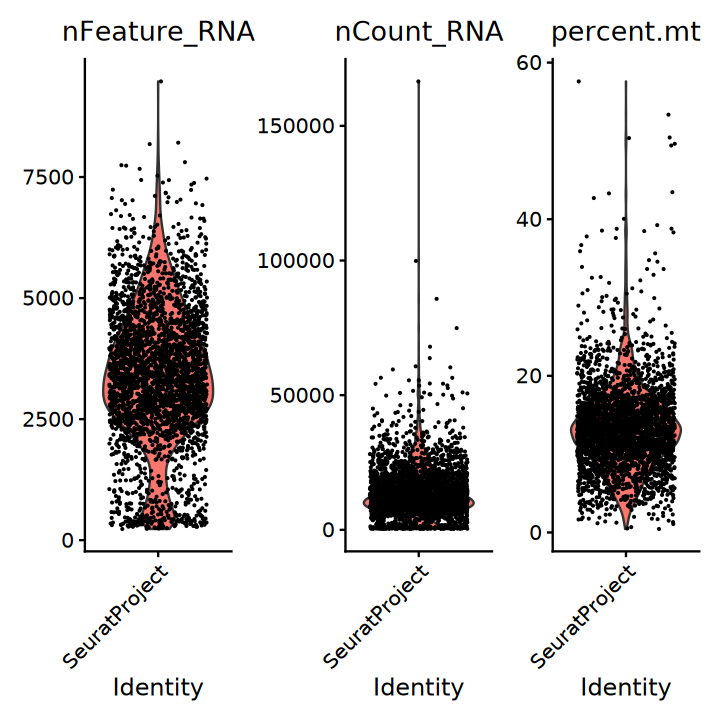

In [349]:
VlnPlot(sc_RNA, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [350]:
sc_RNA <- subset(sc_RNA, subset = nFeature_RNA > 1000 & nFeature_RNA < 7500 & percent.mt < 20)

In [351]:
sc_RNA

An object of class Seurat 
16193 features across 2568 samples within 1 assay 
Active assay: RNA (16193 features, 0 variable features)
 1 layer present: counts

In [352]:
sc_RNA <- NormalizeData(sc_RNA)
sc_RNA <- FindVariableFeatures(sc_RNA, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(sc_RNA)
sc_RNA <- ScaleData(sc_RNA, features = all.genes)
sc_RNA <- RunPCA(sc_RNA, features = VariableFeatures(object = sc_RNA))

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  Lgals3, Malat1, Ndrg1, Fn1, Cp, Nupr1, Col6a1, Fos, Bnip3, 2410006H16Rik 
	   Cited2, Aqp5, Itgb5, Mt1, Ero1l, Atf3, Dusp1, F3, Id3, Tmem150a 
	   Cebpb, Neat1, Tcn2, Zfp36l1, Zfp36, Mxra8, B2m, Igfbp7, Junb, P4ha1 
Negative:  Pclaf, Top2a, H2afz, Ccna2, Birc5, Hmgb2, Smc2, Ccnd1, Anln, Racgap1 
	   Tyms, Mki67, Tk1, Hmgb1, Dek, Cks1b, H2afx, Mcm3, Uhrf1, Diaph3 
	   Cenpe, Tmem97, Smc4, Set, Hspd1, Cenpf, Ran, Ranbp1, Ncl, Cdk1 
PC_ 2 
Positive:  Rps2, Ftl1, Ddit3, Atf4, 2410006H16Rik, Snhg16, Ero1l, Gm41609, 1110038B12Rik, Pgk1 
	   5430416N02Rik, Mt1, Cdkn1a, Snhg1, Rps18, Snhg20, Gpi1, Trib3, Hmox1, Bnip3 
	   Slc3a2, Npm1, Ciart, Mthfd2, Hspa9, Pabpc1, Asns, Hist1h4i, Mt2, Slc2a1 
Negative:  mt-Nd3, Col18a1, Fn1, Fbln2, Cp, Sparc, Col6a1, mt-Nd1, Zfpm2, Cdk14 
	   mt-Nd4, Junb, Nfkbiz, Gpc6, mt-Nd2, Cdk6, Msn, Ltbp1, Airn, mt-Atp6 
	   Vcam1, Emilin1, Col4a5,

In [355]:
sc_RNA <- RunUMAP(sc_RNA, dims = 1:30, verbose = FALSE)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'



In [356]:
sc_RNA <- FindNeighbors(sc_RNA, dims = 1:30, verbose = FALSE)
sc_RNA <- FindClusters(sc_RNA, verbose = FALSE)

In [357]:
sc_RNA <- FindClusters(sc_RNA, verbose = FALSE,resolution = 0.8)

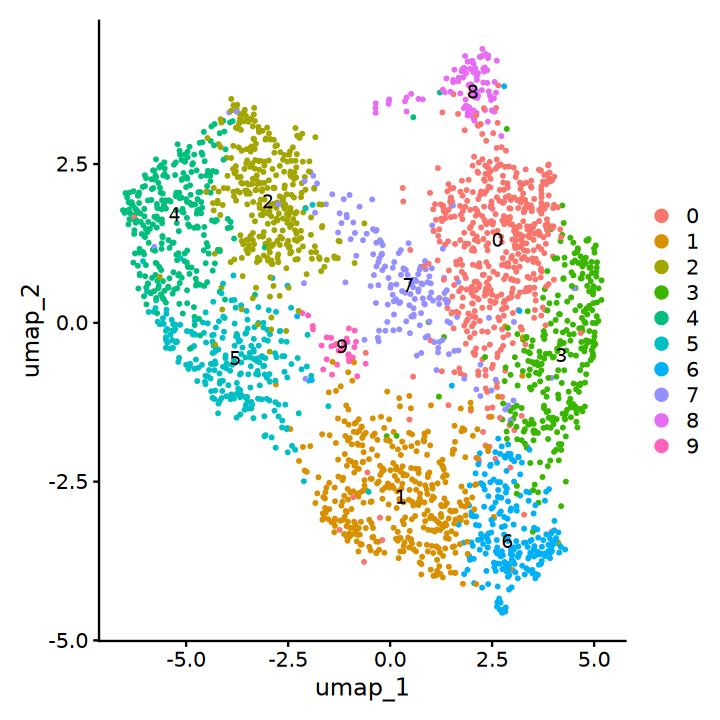

In [358]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_RNA, label = TRUE)

# cluster transfer

In [361]:
sc.all.merge <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/scRNA/cellranger/sc.all.merge.T1T2T3a.harmony.final.refine.rds')

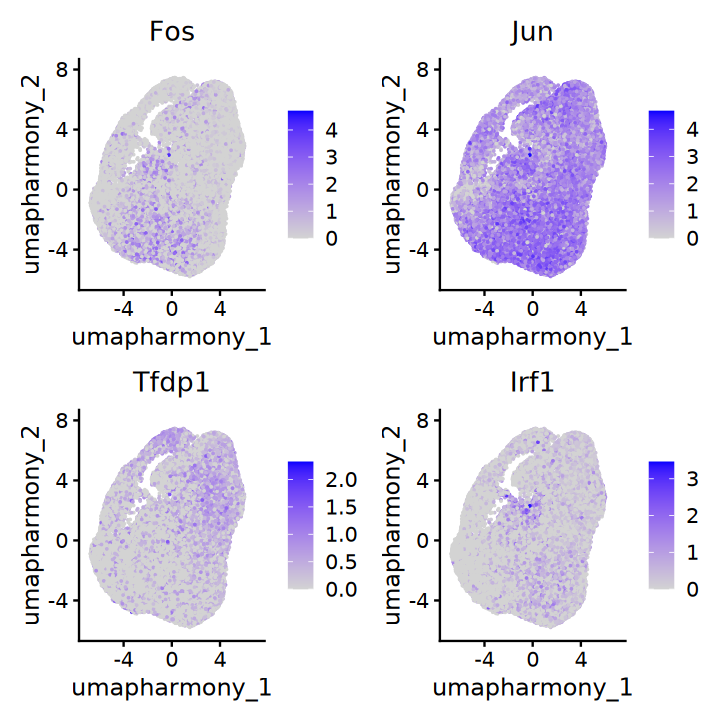

In [343]:
options(repr.plot.width = 6,repr.plot.height = 6)
FeaturePlot(sc.all.merge,features = c('Fos','Jun','Tfdp1','Irf1'),reduction = 'umap.harmony')

In [362]:
sc_RNA.anchors <- FindTransferAnchors(reference = sc.all.merge, query = sc_RNA, dims = 1:50,reference.reduction = "pca")
predictions <- TransferData(anchorset = sc_RNA.anchors, refdata = sc.all.merge$seurat_clusters_rename, dims = 1:50)
sc_RNA <- AddMetaData(sc_RNA, metadata = predictions)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 8701 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [1]:
options(repr.plot.width = 5,repr.plot.height = 5) 
DimPlot(sc_RNA, label = TRUE,group.by = 'predicted.id',cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600'))

ERROR: Error in DimPlot(sc_RNA, label = TRUE, group.by = "predicted.id", cols = c("#a6cee3", : could not find function "DimPlot"


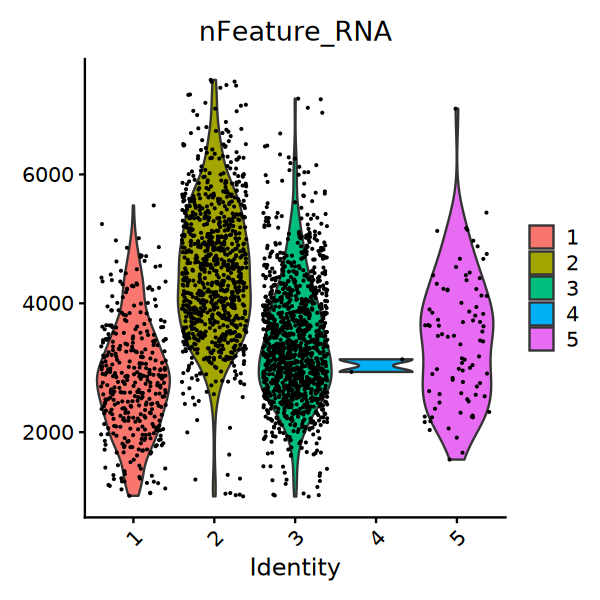

In [30]:
VlnPlot(sc_RNA,group.by = 'predicted.id',features = "nFeature_RNA")

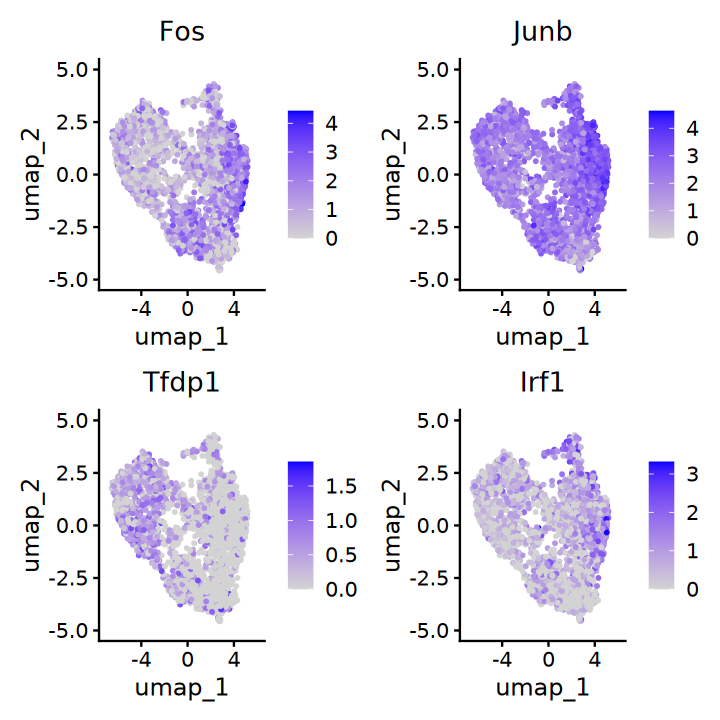

In [364]:
options(repr.plot.width = 6,repr.plot.height = 6)
FeaturePlot(sc_RNA,features = c('Fos','Junb','Tfdp1','Irf1'))

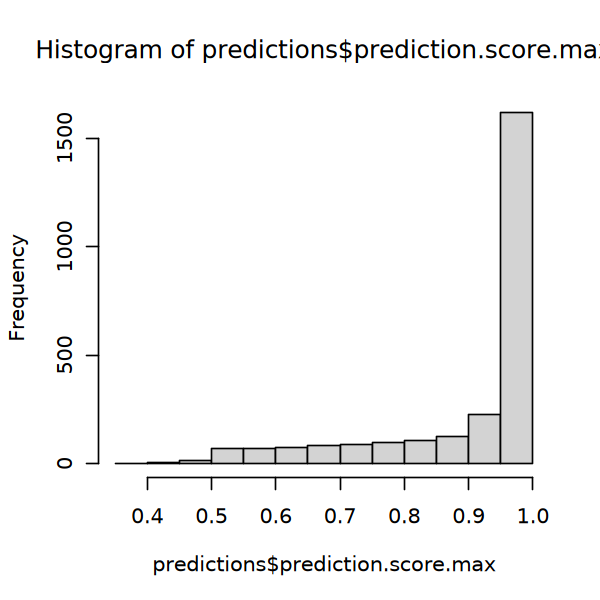

In [31]:
hist(predictions$prediction.score.max)

In [32]:
sc_RNA@meta.data <- cbind(sc_RNA@meta.data,
                      as.data.frame(sc_RNA@reductions$umap@cell.embeddings)[rownames(sc_RNA@meta.data),])

In [33]:
sc_RNA@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters,RNA_snn_res.0.3,RNA_snn_res.0.4,RNA_snn_res.0.6,predicted.id,prediction.score.2,prediction.score.1,prediction.score.3,prediction.score.4,prediction.score.5,prediction.score.max,umap_1,umap_2
,<fct>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACAGCCAGGCCATT-1,SeuratProject,59544,7436,13.786444,4,1,1,0,4,2,1.000000000,0.000000000,0.000000000,0.000000000,0.0000000,1.0000000,-5.9393898,0.6195063
AAACATGCACCCTCAC-1,SeuratProject,11604,3725,10.617029,3,0,0,3,2,3,0.000000000,0.236366197,0.763633803,0.000000000,0.0000000,0.7636338,3.6502311,-0.8035753
AAACATGCAGGCTACT-1,SeuratProject,17107,4309,17.793886,3,0,0,3,2,3,0.004505803,0.130255489,0.584065686,0.000000000,0.2811730,0.5840657,1.3199842,-0.2236029
AAACCGCGTCTTGCTG-1,SeuratProject,17680,4029,19.049774,1,0,0,2,1,3,0.000000000,0.010647426,0.989352574,0.000000000,0.0000000,0.9893526,3.2400333,-0.8330461
AAACCGCGTGGTTCTT-1,SeuratProject,9952,2878,18.488746,2,1,1,0,3,2,1.000000000,0.000000000,0.000000000,0.000000000,0.0000000,1.0000000,-3.1798540,2.5502737
AAACCGGCAAGGACCA-1,SeuratProject,14508,3857,8.422939,2,1,1,0,3,2,1.000000000,0.000000000,0.000000000,0.000000000,0.0000000,1.0000000,-2.5180348,1.6121159
AAACCGGCACAAAGGT-1,SeuratProject,15842,3891,17.624037,0,0,0,2,1,3,0.000000000,0.000000000,1.000000000,0.000000000,0.0000000,1.0000000,3.8435633,1.6311522
AAACCGGCAGTGAACG-1,SeuratProject,10179,3167,15.404264,7,0,0,3,2,2,0.585503462,0.017201335,0.397295204,0.000000000,0.0000000,0.5855035,-1.8605426,2.1261519
AAACGGATCCAGGTTG-1,SeuratProject,4288,1633,8.115672,6,0,0,1,1,3,0.021438701,0.113518931,0.865042368,0.000000000,0.0000000,0.8650424,4.1253373,-3.3002197


In [34]:
table(sc_RNA@meta.data$predicted.id)


   1    2    3    4    5 
 377  868 1235    2   86 

In [35]:
saveRDS(sc_RNA,file='/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA.rds')

In [36]:
write.table(sc_RNA@meta.data,'/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv',col.names = NA,quote=F,sep=',')

In [1]:
library(Seurat)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [2]:
sc_RNA <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA.rds')

In [4]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/multiome_UMAP.pdf',width=5,height=5)
options(repr.plot.width = 5,repr.plot.height = 5) 
DimPlot(sc_RNA, label = TRUE,group.by = 'predicted.id',cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600'))
dev.off()

png 
  2